<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/stack_ensemble_h2o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stack-Ensemble Model with H20

H2O\'s Stacked Ensemble method is a supervised ensemble machine learning algorithm that finds the optimal combination of a collection of prediction algorithms using a process called stacking. Like all supervised models in H2O, Stacked Ensemeble supports regression, binary classification, and multiclass classification.

To create stacked ensembles with H2O in R, you can follow these general steps:

1.   **Set up the Ensemble:** Specify a list of L base algorithms (with a specific set of model parameters) and specify a metalearning algorithm

2.   **Grid Search**: Find the best base model for each L-base algorithms using hyperprameter grid search

3.  **Train L-base models** : Perform k-fold cross-validation on each of these learners and collect the cross-validated predicted values from each of the L algorithms.

4.   **Prediction**: The N cross-validated predicted values from each of the L algorithms can be combined to form a new N x L matrix. This matrix, along with the original response vector, is called the \"level-one\" data. (N = number of rows in the training set.

5.  T**rain with the Metalearner**: Train the metalearning algorithm on the level-one data. The \"ensemble model\" consists of the L base learning models and the metalearning model, which can then be used to generate predictions on a test set.

6.   **Predict with the stacked ensemble**: Once the stack ensemble is trained, you can use it to make predictions on new, unseen data.

7.  **Shutdown the H2O cluster**: After you have finished using H2O, it's good practice to shut down the H2O cluster by running **`h2o.shutdown()`**.


### Install h20, Tidymodesl and Metrics

In [3]:
install.packages("h2o")
install.packages("tidymodels")
install.packages("Metrics")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘RCurl’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘Rcpp’, ‘diagram’, ‘lava’, ‘listenv’, ‘parallelly’, ‘prodlim’, ‘future’, ‘warp’, ‘iterators’, ‘lhs’, ‘DiceDesign’, ‘patchwork’, ‘globals’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘foreach’, ‘GPfit’, ‘modelenv’, ‘dials’, ‘hardhat’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Load Packages

In [4]:
library(tidyverse)
library(tidymodels)
library(Metrics)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.0 ──

✔ broom        1.0.5     ✔ rsample      1.1.1
✔ dials        1.2.0     ✔ tune         1.1.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.0     ✔ yardstick    1.2.0
✔ recipes      1.0.6     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/


Attaching package: ‘Metrics’


The following objects are masked from ‘package:yardstick’:

    accuracy, mae, mape, mase, precision, recall, rmse, smape




### Data

In [5]:
# define file from my github
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/USA/gp_soil_data_syn.csv"
mf<-read_csv(url(urlfile))
# Create a data-frame
df<-mf %>% dplyr::select(SOC, DEM, Slope, TPI,MAT, MAP,NDVI, NLCD, FRG)%>%
    glimpse()

Rows: 1408 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): NLCD, FRG
dbl (8): ID, SOC, DEM, Slope, TPI, MAP, MAT, NDVI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,408
Columns: 9
$ SOC   <dbl> 1.900, 2.644, 0.800, 0.736, 15.641, 8.818, 3.782, 6.641, 4.803, …
$ DEM   <dbl> 2825.1111, 2535.1086, 1716.3300, 1649.8933, 2675.3113, 2581.4839…
$ Slope <dbl> 18.981682, 14.182393, 1.585145, 9.399726, 12.569353, 6.358553, 1…
$ TPI   <dbl> -0.91606224, -0.15259802, -0.39078590, -2.54008722, 7.40076303, …
$ MAT   <dbl> 4.709227, 4.648000, 6.360833, 10.265385, 2.798550, 6.358550, 7.0…
$ MAP   <dbl> 613.6979, 597.7912, 201.5091, 298.2608, 827.4680, 679.1392, 508.…
$ NDVI  <dbl> 0.6845260, 0.7557631, 0.2215059, 0.2785148, 0.7337426, 0.7017139…
$ NLCD  <chr> "Forest", "Forest", "Shrubland", "Shrubland", "Forest", "Forest"…
$ FRG   <chr> "Fire Regime Group IV", "Fire Regime Group IV", "Fire Regime Gro…


### Data Preprocessing

#### Convert to factor

In [6]:
df$NLCD <- as.factor(df$NLCD)
df$FRG <- as.factor(df$FRG)

#### Data Split

In [7]:
set.seed(1245)   # for reproducibility
split_01 <- initial_split(df, prop = 0.8, strata = SOC)
train <- split_01 %>% training()
test <-  split_01 %>% testing()

#### Scaling

In [8]:
train[-c(1, 8,9)] = scale(train[-c(1,8,9)])
test[-c(1, 8,9)] = scale(test[-c(1,8,9)])

### Import h2o

In [9]:
library(h2o)
h2o.init()
#disable progress bar for RMarkdown
h2o.no_progress()
# Optional: remove anything from previous session
h2o.removeAll()


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:lubridate’:

    day, hour, month, week, year


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc





H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpEfywVn/file3162987a622/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpEfywVn/file3162f6199b/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: ...... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 616 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.40.0.4 
    H2O cluster version age:    2 months and 22 days 
    H2O cluster name:           H2O_started_from_R_root_yqz807 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.17 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version: 

### Import data to h2o cluster

In [10]:
h_df=as.h2o(df)
h_train = as.h2o(train)
h_test = as.h2o(test)

In [11]:
train.xy<- as.data.frame(h_train)
test.xy<- as.data.frame(h_test)

### Define response and predictors

In [12]:
y <- "SOC"
x <- setdiff(names(h_df), y)

### Train Base-Learners with Grid Search

1. Generalized Linear Models (GLM)

In [13]:
# GLM Hyperprameter
glm_hyper_params <-list(
             alpha = c(0,0.25,0.5,0.75,1),
             lambda = c(1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0))

# GLM Hyperprameter Grid Search
GLM_grid <- h2o.grid(
                  algorithm="glm",
                  grid_id = "glm_grid_IDs",
                  x= x,
                  y = y,
                  training_frame = h_train,
                  #validation_frame = h_valid,
                  standardize = TRUE,
                  nfolds=5,
                  keep_cross_validation_predictions = TRUE,
                  hyper_params = glm_hyper_params,
                  seed = 42)

# Get GLM Grid parameters
glm_get_grid <- h2o.getGrid("glm_grid_IDs",sort_by="RMSE",decreasing=FALSE)
glm_get_grid@summary_table[1,]

# Number of GLM models
length(GLM_grid@model_ids)

# The Best GLM Model
best_GLM <- h2o.getModel(glm_get_grid@model_ids[[1]])
summary(best_GLM)

Warning message in h2o.getGrid(grid_id = grid_id):
“Adding alpha array to hyperparameter runs slower with gridsearch. This is due to the fact that the algo has to run initialization for every alpha value. Setting the alpha array as a model parameter will skip the initialization and run faster overall.”
Warning message in h2o.getGrid("glm_grid_IDs", sort_by = "RMSE", decreasing = FALSE):
“Adding alpha array to hyperparameter runs slower with gridsearch. This is due to the fact that the algo has to run initialization for every alpha value. Setting the alpha array as a model parameter will skip the initialization and run faster overall.”


,alpha,lambda,model_ids,rmse
,<chr>,<chr>,<chr>,<dbl>
1,1.0,0.01,glm_grid_IDs_model_20,3.913585


[1] 40

Model Details:

H2ORegressionModel: glm
Model Key:  glm_grid_IDs_model_20 
GLM Model: summary
    family     link         regularization number_of_predictors_total
1 gaussian identity Lasso (lambda = 0.01 )                         16
  number_of_active_predictors number_of_iterations   training_frame
1                          11                    1 train_sid_96fd_3

H2ORegressionMetrics: glm
** Reported on training data. **

MSE:  14.92919
RMSE:  3.863831
MAE:  2.751655
RMSLE:  0.5254711
Mean Residual Deviance :  14.92919
R^2 :  0.4139503
Null Deviance :28684.03
Null D.o.F. :1125
Residual Deviance :16810.27
Residual D.o.F. :1114
AIC :6265.386



H2ORegressionMetrics: glm
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  15.31615
RMSE:  3.913585
MAE:  2.788419
RMSLE:  0.5316645
Mean Residual Deviance :  15.31615
R^2 :  0.3987602
Null Deviance :28740.54
Null D.o.F. :1125
Residual Deviance :

2. Random Forest

In [14]:
# RF Hyper-parameters
RF_hyper_params <-list(
              ntrees  = seq(100, 5000, by = 100),
              max_depth=c(10,20,30,40,50),
              sample_rate=c(0.7, 0.8, 0.9, 1.0)
              )

# RF Hyper-parameters Search Criteria
RF_search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 100,
                        max_runtime_secs = 100,
                        stopping_tolerance = 0.001,
                        stopping_rounds = 2,
                        seed = 42)

# RF Grid Search
RF_grid <- h2o.grid(
                  algorithm="randomForest",
                  grid_id = "RF_grid_IDs",
                  x = x,
                  y = y,
                  training_frame = h_train,
                  #validation_frame = h_valid,
                  stopping_metric = "RMSE",
                  #fold_assignment ="Stratified",
                  nfolds=5,
                  keep_cross_validation_predictions = TRUE,
                  keep_cross_validation_models = TRUE,
                  hyper_params = RF_hyper_params,
                  search_criteria = RF_search_criteria,
                  seed = 42)

# Number RF models
length(RF_grid@model_ids)

# Get RF Grid parameters
RF_get_grid <- h2o.getGrid("RF_grid_IDs",
                           sort_by="RMSE",
                           decreasing=F)
# The Best RF model
best_RF <- h2o.getModel(RF_get_grid@model_ids[[1]])
best_RF

[1] 4

Model Details:

H2ORegressionModel: drf
Model ID:  RF_grid_IDs_model_2 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1             151                      151              991855        17
  max_depth mean_depth min_leaves max_leaves mean_leaves
1        27   20.94702        441        584   518.12585


H2ORegressionMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  NaN
RMSE:  NaN
MAE:  NaN
RMSLE:  NaN
Mean Residual Deviance :  NaN



H2ORegressionMetrics: drf
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  4.131365
RMSE:  2.032576
MAE:  0.9286309
RMSLE:  0.299807
Mean Residual Deviance :  4.131365


Cross-Validation Metrics Summary: 
                           mean       sd cv_1_valid cv_2_valid cv_3_valid
mae                    0.929322 0.163260   0.839322   0.825890   1.055624
mean_resi

3. Gradient Boosting Machine (GBM)

In [15]:
# GBM Hyper-parameters
GBM_hyper_params = list( ntrees = c(100,500, 1000, 5000),
                     max_depth = c(2,5,8),
                     min_rows = c(8,10, 12),
                     learn_rate = c(0.001,0.05,0.06),
                     sample_rate = c(0.4,0.5,0.6, 0.7),
                     col_sample_rate = c(0.4,0.5,0.6),
                     col_sample_rate_per_tree = c(0.4,0.5,0.6))

# GBM Hyper-parameters Search Criteria
GBM_search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 20,
                        max_runtime_secs = 100,
                        stopping_tolerance = 0.001,
                        stopping_rounds = 2,
                        seed = 42)

# GBM Hyper-parameters Grid Search
GBM_grid <- h2o.grid(
                  algorithm="gbm",
                  grid_id = "GBM_grid_ID",
                  x= x,
                  y = y,
                  training_frame = h_train,
                  #validation_frame = h_valid,
                  distribution ="AUTO",
                  stopping_metric = "RMSE",
                  #fold_assignment ="Stratified",
                  nfolds=5,
                  keep_cross_validation_predictions = TRUE,
                  keep_cross_validation_models = TRUE,
                  hyper_params = GBM_hyper_params,
                  search_criteria = GBM_search_criteria,
                  seed = 42)

# Number GBM models
length(GBM_grid@model_ids)

# Get GBM Grid parameters
GBM_get_grid <- h2o.getGrid("GBM_grid_ID",
                           sort_by="RMSE",
                           decreasing=F)
#  the Best GBM Model
best_GBM <- h2o.getModel(GBM_get_grid@model_ids[[1]])
best_GBM

[1] 4

Model Details:

H2ORegressionModel: gbm
Model ID:  GBM_grid_ID_model_2 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1             273                      273               93355         8
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         8    8.00000          9         36    22.43590


H2ORegressionMetrics: gbm
** Reported on training data. **

MSE:  1.621173
RMSE:  1.273253
MAE:  0.8083403
RMSLE:  0.2259199
Mean Residual Deviance :  1.621173



H2ORegressionMetrics: gbm
** Reported on cross-validation data. **
** 5-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  4.858496
RMSE:  2.2042
MAE:  1.276915
RMSLE:  0.3410892
Mean Residual Deviance :  4.858496


Cross-Validation Metrics Summary: 
                           mean       sd cv_1_valid cv_2_valid cv_3_valid
mae                    1.277527 0.150975   1.228899   1.184375   1.497392
mean_residual_deviance 4.863157 1.3798

4. eXtreme Gradient Boosting (XGBoost)

In [16]:
# hyper parameters
XGBoost_hyper_params = list( ntrees = seq(50,500,50),
                     max_depth = seq(1,120,1),
                     min_rows = c(1,5,10,20,50,100),
                     learn_rate = seq(0.001,0.01,0.001),
                     sample_rate = seq(0.3,1,0.05),
                     col_sample_rate = seq(0.3,1,0.05),
                     col_sample_rate_per_tree = seq(0.3,1,0.05))

# Search Criteria
XGBoost_search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 200,
                        max_runtime_secs = 900,
                        stopping_tolerance = 0.001,
                        stopping_rounds = 2,
                        seed = 1345767)
# Gird Search
XGBoost_grid <- h2o.grid(
                  algorithm="xgboost",
                  grid_id = "XGBoost_grid_ID",
                  x= x,
                  y = y,
                  training_frame = h_train,
                  stopping_metric = "rmse",
                  #fold_assignment ="Stratified",
                  nfolds=10,
                  keep_cross_validation_predictions = TRUE,
                  keep_cross_validation_models = TRUE,
                  hyper_params = XGBoost_hyper_params,
                  search_criteria = XGBoost_search_criteria,
                  seed = 42)

# Number XGBoost models
length(XGBoost_grid@model_ids)

# Get XGBoost Grid parameters
XGBoost_get_grid <- h2o.getGrid("XGBoost_grid_ID",
                           sort_by="RMSE",
                           decreasing=F)
#  the Best XGBoost Model
best_XGBoost <- h2o.getModel(XGBoost_get_grid@model_ids[[1]])
best_XGBoost

[1] 40

Model Details:

H2ORegressionModel: xgboost
Model ID:  XGBoost_grid_ID_model_28 
Model Summary: 
  number_of_trees
1             450


H2ORegressionMetrics: xgboost
** Reported on training data. **

MSE:  1.16847
RMSE:  1.080958
MAE:  0.6325956
RMSLE:  0.1018772
Mean Residual Deviance :  1.16847



H2ORegressionMetrics: xgboost
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  4.515145
RMSE:  2.124887
MAE:  1.172908
RMSLE:  0.2666398
Mean Residual Deviance :  4.515145


Cross-Validation Metrics Summary: 
                           mean       sd cv_1_valid cv_2_valid cv_3_valid
mae                    1.171795 0.261801   1.048656   1.002419   1.716432
mean_residual_deviance 4.503427 2.305783   3.612036   2.568831   8.180577
mse                    4.503427 2.305783   3.612036   2.568831   8.180577
r2                     0.826234 0.059529   0.813822   0.901299   0.771599
residual_deviance     

5. Deep Neural Network (DNN)

In [17]:
# DNN Hyper-parameters
DNN_hyper_params <- list(
                     activation = c("Rectifier",
                                    "Maxout",
                                    "Tanh",
                                    "RectifierWithDropout",
                                    "MaxoutWithDropout",
                                    "TanhWithDropout"),
                     hidden = list( c(50, 50, 50, 50),
                                   c(100, 100, 100), c(200, 200, 200)),
                     epochs = c(50, 100, 200, 500),
                     l1 = c(0, 0.00001, 0.0001),
                     l2 = c(0, 0.00001, 0.0001),
                     rate = c(0, 01, 0.005, 0.001),
                     rate_decay = c(0.5, 1.0, 1.5),
                     rate_annealing = c(1e-5, 1e-6, 1e-5),
                     rho = c(0.9, 0.95, 0.99, 0.999),
                     epsilon = c(1e-06, 1e-08, 1e-09),
                     momentum_start = c(0, 0.5),
                     momentum_stable = c(0.99, 0.5, 0),
                     regression_stop = c(1e-05, 1e-06,1e-07),
                     input_dropout_ratio = c(0, 0.0001, 0.001),
                     max_w2 = c(10, 100, 1000, 3.4028235e+38)
                     )

# DNN Hyper-parameters Search criteria
DNN_search_criteria <- list(strategy = "RandomDiscrete",
                        max_models = 100,
                        max_runtime_secs = 100,
                        stopping_tolerance = 0.001,
                        stopping_rounds = 3,
                        seed = 1345767)

# DNN Hyper-parameters Grid Search
DNN_grid <- h2o.grid(
                  algorithm="deeplearning",
                  grid_id = "DNN_grid_IDs",
                  x= x,
                  y = y,
                  standardize = TRUE,
                  shuffle_training_data = TRUE,
                  training_frame = h_train,
                  #validation_frame = h_valid,
                  distribution ="AUTO",
                  stopping_metric = "RMSE",
                  nfolds= 5,
                  keep_cross_validation_predictions = TRUE,
                  keep_cross_validation_models = TRUE,
                  hyper_params = DNN_hyper_params,
                  search_criteria = DNN_search_criteria,
                  seed = 42)

# Number DNN models
length(DNN_grid@model_ids)

# Get DNN Grid parameters
DNN_get_grid <- h2o.getGrid("DNN_grid_IDs",
                           sort_by="RMSE",
                           decreasing=F)
#The Best DNN model
best_DNN <- h2o.getModel(DNN_get_grid@model_ids[[1]])
best_DNN

[1] 3

Model Details:

H2ORegressionModel: deeplearning
Model ID:  DNN_grid_IDs_model_1 
Status of Neuron Layers: predicting SOC, regression, gaussian distribution, Quadratic loss, 22,201 weights/biases, 268.5 KB, 26,965 training samples, mini-batch size 1
  layer units        type dropout       l1       l2 mean_rate rate_rms momentum
1     1    18       Input  0.10 %       NA       NA        NA       NA       NA
2     2   100 TanhDropout 50.00 % 0.000100 0.000010  0.109958 0.306117 0.000000
3     3   100 TanhDropout 50.00 % 0.000100 0.000010  0.005655 0.005809 0.000000
4     4   100 TanhDropout 50.00 % 0.000100 0.000010  0.010240 0.026693 0.000000
5     5     1      Linear      NA 0.000100 0.000010  0.000360 0.000117 0.000000
  mean_weight weight_rms mean_bias bias_rms
1          NA         NA        NA       NA
2    0.000699   0.136715  0.002333 0.057540
3    0.000533   0.100516 -0.015051 0.124785
4    0.001179   0.096350  0.003299 0.049581
5   -0.012108   0.116676 -0.004180 0.000000


H2OR

### Stack-Ensemble Model: The Best of Families

In [18]:
# rf-parameters
rf_params <-   list(
                    ntrees = 2000,
                    max_depth =25,
                    sample_rate = 0.8,
                    stopping_tolerance = 0.001,
                    stopping_rounds = 3,
                    stopping_metric = "RMSE")


stack_best <-h2o.stackedEnsemble(
                               model_id = "stack_RF_ID",
                               x= x,
                               y = y,
                               training_frame = h_train,
                               #validation_frame = h_valid,
                               base_models = list(best_GLM,
                                                  best_RF,
                                                  best_GBM,
                                                  best_XGBoost,
                                                  best_DNN
                                                  ),
                               metalearner_algorithm = "drf",
                               metalearner_params = rf_params,
                               metalearner_nfolds = 5,
                               seed = 42
                               )
stack_best

Model Details:

H2ORegressionModel: stackedensemble
Model ID:  stack_RF_ID 
Model Summary for Stacked Ensemble: 
                                         key
1                          Stacking strategy
2       Number of base models (used / total)
3           # GBM base models (used / total)
4       # XGBoost base models (used / total)
5           # GLM base models (used / total)
6           # DRF base models (used / total)
7  # DeepLearning base models (used / total)
8                      Metalearner algorithm
9         Metalearner fold assignment scheme
10                        Metalearner nfolds
11                   Metalearner fold_column
12        Custom metalearner hyperparameters
                                                                                                                                                                  value
1                                                                                                                                     

#### Prediction

In [19]:
stack.test.best<-as.data.frame(h2o.predict(object = stack_best, newdata = h_test))
test.xy$Stack_SOC_best<-stack.test.best$predict

In [20]:
RMSE.best<- Metrics::rmse(test.xy$SOC, test.xy$Stack_SOC_best)
MAE.best<- Metrics::mae(test.xy$SOC, test.xy$Stack_SOC_best)

# Print results
paste0("RMSE: ", round(RMSE.best,2))
paste0("MAE: ", round(MAE.best,2))

[1] "RMSE: 2.99"

[1] "MAE: 2.1"

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


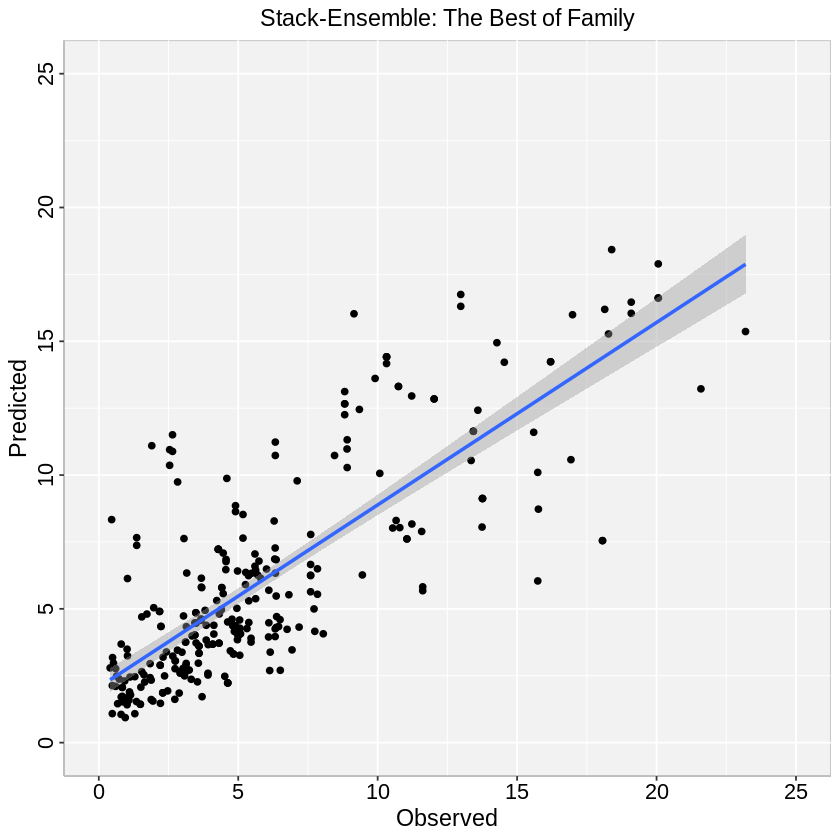

In [21]:
ggplot(test.xy, aes(SOC,Stack_SOC_best)) +
  geom_point() +
  geom_smooth(method = "lm")+
  ggtitle("Stack-Ensemble: The Best of Family") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

### Stack-Ensemble Model - All Models

In [22]:
all_01 = append(GLM_grid@model_ids, RF_grid@model_ids)
all_02<-append(all_01, XGBoost_grid@model_ids)
all_03<-append(all_02,DNN_grid@model_ids)
all_04<-append(all_03,GBM_grid@model_ids)
length(all_04)

[1] 91

In [23]:
stack_all<- h2o.stackedEnsemble(
                               model_id = "stack_Model_ALL_IDs",
                               x= x,
                               y = y,
                               training_frame = h_train,
                               base_models = all_04,
                               metalearner_algorithm = "drf",
                               metalearner_nfolds = 5,
                               metalearner_params = rf_params,
                               keep_levelone_frame = TRUE,
                               seed=123)
stack_all

Model Details:

H2ORegressionModel: stackedensemble
Model ID:  stack_Model_ALL_IDs 
Model Summary for Stacked Ensemble: 
                                         key
1                          Stacking strategy
2       Number of base models (used / total)
3           # GBM base models (used / total)
4       # XGBoost base models (used / total)
5           # GLM base models (used / total)
6           # DRF base models (used / total)
7  # DeepLearning base models (used / total)
8                      Metalearner algorithm
9         Metalearner fold assignment scheme
10                        Metalearner nfolds
11                   Metalearner fold_column
12        Custom metalearner hyperparameters
                                                                                                                                                                  value
1                                                                                                                             

##### Prediction

In [24]:
stack.test.all<-as.data.frame(h2o.predict(object = stack_all, newdata = h_test))
test.xy$Stack_SOC_all<-stack.test.all$predict

In [25]:
RMSE.all<- Metrics::rmse(test.xy$SOC, test.xy$Stack_SOC_all)
MAE.all<- Metrics::mae(test.xy$SOC, test.xy$Stack_SOC_all)

# Print results
paste0("RMSE: ", round(RMSE.all,2))
paste0("MAE: ", round(MAE.all,2))

[1] "RMSE: 3.1"

[1] "MAE: 2.15"

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


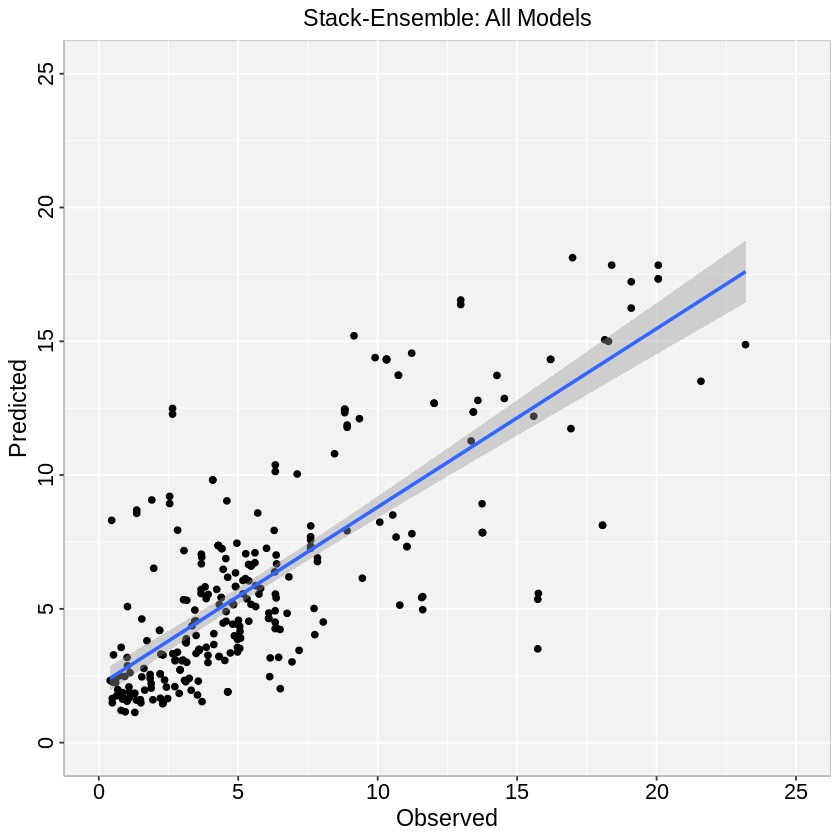

In [26]:

ggplot(test.xy, aes(SOC,Stack_SOC_all)) +
  geom_point() +
  geom_smooth(method = "lm")+
  ggtitle("Stack-Ensemble: All Models") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,25), breaks=seq(0, 25, 5))+
  scale_y_continuous(limits=c(0,25), breaks=seq(0, 25, 5)) +
  # Flip the bars
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

#